# Script to calculate historical SPEI (multiple models)

- adapted from Sarah's Chapman's notebook
- includes code from Eszter's drought notebook
- adapted 'make_cmip6_filepath' function to accomodate multiple model fpaths
- code to get the institute for each model

Some useful links
https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa

In [1]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
import copy
import climate_indices
from climate_indices import compute, indices
import iris
import iris.coord_categorisation
import os 

def get_dates(cube, verbose=False):
    dates = cube.coord('time').units.num2date(cube.coord('time').points)
    dates = [dt(date.year, date.month, date.day) for date in dates]
    if verbose is True:
        print(dates)
    else:
        print(dates[0], '–', dates[-1])
    return(dates)

def make_cmip6_filepath(institute, model, scenario, variant, experiment, table_id, variable, grid, version, time_range,
                        data_root="/badc/cmip6/data/CMIP6/"):
    """
    Make a file path for a cmip6 dataset for a single variable
    Historical runs (1850-2014) are in `/badc/cmip6/data/CMIP6/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
    Scenario runs are in `/badc/cmip6/data/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`, e.g. `r1i1p1f2`, where the numbers are the indexes for:  
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where  
       * `gm`: global mean data  
       * `gn`: data reported on a model's native grid  
       * `gr1`: regridded data reported on a grid other than the native grid and other than the preferred target grid  
    It is likely the `grid` will be the native grid, i.e. `gn`
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    
    `variable` generally follows the list on https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example 
       `tas`: air_temperature 
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
    AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO, CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM, HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS, NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """
    # get base path
    path = str(DATA_ROOT / scenario / institute / model / experiment)
    #print(os.listdir(path))
    
    # get path for variant
    if variant is None:
        # select first variant
        dir_list = os.listdir(path)
        variant_list = [x for x in dir_list if x.startswith('r')]
    else:
        variant_list = [variant]
    
    # update path
    var = [x for x in variant_list if x.startswith('r1i1p1')]
    if len(var) == 0:
        print(variant_list)
        var = [x for x in variant_list if x.startswith('r')]
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable)
    else:
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable) 
        #print(path)
    # get path for grid
    if grid is None:
        # select first grid (usually only 1)
        dir_list = os.listdir(path)
        grid_list = [x for x in dir_list if x.startswith('g')]
    else:
        grid_list = [grid]
        
    # update path
    path = path + '/' + str(grid_list[0])
    
    # get version path
    if version is None:
        dir_list2 = os.listdir(path)
        version_list = [x for x in dir_list2 if x.startswith('v')]
    else:
        version_list = [version]
    
    # update path
    path = path + '/' + str(version_list[0]) + '/'
    print(path)
    print(os.listdir(path))
    return(path+ '*.nc')

# test
DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
model = "UKESM1-0-LL"
fp = make_cmip6_filepath(
        institute="MOHC", scenario='CMIP', model=model, experiment='historical', variant=None,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )

/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/pr/gn/v20190406/
['pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-194912.nc', 'pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc']


In [2]:
# create dictionary of models and institutes
basepath = '/badc/cmip6/data/CMIP6/CMIP/'
institute_list = os.listdir(basepath)
model_inst_dict = {}

# loop over institutes
for inst in institute_list:
    model_list = os.listdir(basepath + inst + '/')
    
    # for each institute list models and store in dictionary
    for model_temp in model_list:
        model_inst_dict[model_temp] = inst
        #print(model_inst_dict)
        #assert False
    
    # correction for UKESM which is used by multiple centres - we want MOHC only
    model_inst_dict['UKESM1-0-LL'] = 'MOHC'
#print(os.listdir(path))
print(model_inst_dict)

{'TaiESM1': 'AS-RCEC', 'UKESM1-0-LL': 'MOHC', 'AWI-CM-1-1-MR': 'AWI', 'AWI-ESM-1-1-LR': 'AWI', 'BCC-CSM2-MR': 'BCC', 'BCC-ESM1': 'BCC', 'CAMS-CSM1-0': 'CAMS', 'CAS-ESM2-0': 'CAS', 'FGOALS-f3-L': 'CAS', 'FGOALS-g3': 'CAS', 'IITM-ESM': 'CCCR-IITM', 'CanESM5': 'CCCma', 'CanESM5-CanOE': 'CCCma', 'CMCC-CM2-HR4': 'CMCC', 'CMCC-CM2-SR5': 'CMCC', 'CMCC-ESM2': 'CMCC', 'CNRM-CM6-1': 'CNRM-CERFACS', 'CNRM-CM6-1-HR': 'CNRM-CERFACS', 'CNRM-ESM2-1': 'CNRM-CERFACS', 'ACCESS-ESM1-5': 'CSIRO', 'ACCESS-CM2': 'CSIRO-ARCCSS', 'E3SM-1-0': 'E3SM-Project', 'E3SM-1-1': 'E3SM-Project', 'E3SM-1-1-ECA': 'E3SM-Project', 'EC-Earth3': 'EC-Earth-Consortium', 'EC-Earth3-AerChem': 'EC-Earth-Consortium', 'EC-Earth3-CC': 'EC-Earth-Consortium', 'EC-Earth3-LR': 'EC-Earth-Consortium', 'EC-Earth3-Veg': 'EC-Earth-Consortium', 'EC-Earth3-Veg-LR': 'EC-Earth-Consortium', 'EC-Earth3P-VHR': 'EC-Earth-Consortium', 'FIO-ESM-2-0': 'FIO-QLNM', 'MPI-ESM-1-2-HAM': 'HAMMOZ-Consortium', 'INM-CM4-8': 'INM', 'INM-CM5-0': 'INM', 'IPSL-CM5A2

In [3]:

# load a file -- NEED TO CHANGE REGION
assert False

DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
pr_datasets = {}
tas_datasets = {}
expt = "historical" #"ssp585"
scenario = 'CMIP' # "ScenarioMIP"
# read in monthly data
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5',
          'CESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM',
          'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM-1-2-HAM',
          'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM',
          'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'] 

#for model in ["HadGEM3-GC31-LL"]:
#for model in ['UKESM1-0-LL']:
for model in models:
    print(model)
    institute = model_inst_dict[model]
    print(institute)
    
    if model in ['UKESM1-0-LL']:  #something wrong with UKESM r1i1p1 variant (hdf error)
        variant = 'r2i1p1f2'
    else:
        variant = None
    fp = make_cmip6_filepath(
        institute=institute, scenario=scenario, model=model, experiment=expt, variant=variant,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )
    
    pr_cube = xr.open_mfdataset(fp)
    
    # useful guide here: https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_02_Xarray_subset_slicing_plot_CMIP6.html
    # change longitudes from 0,360 to -180,180
    pr_cube = pr_cube.assign_coords(lon=(((pr_cube.lon + 180) % 360) - 180)).sortby('lon')
    
    # select data over Ghana
    ghana_pr = pr_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
    #print(ghana_pr.pr)
    
    pr_datasets[model] = ghana_pr
    
    fp = make_cmip6_filepath(
        institute=institute, scenario=scenario, model=model, experiment=expt, variant=variant,
        table_id="Amon", variable="tas", grid=None, version=None, time_range="*"
    )
    print(fp)
    tas_cube = xr.open_mfdataset(fp)
    
    tas_cube = tas_cube.assign_coords(lon=(((tas_cube.lon + 180) % 360) - 180)).sortby('lon')
    
    # select data over Ghana
    ghana_tas = tas_cube.sel(lat=slice(4.5,11.4), lon=slice(-3.5,1))
    #print(ghana_tas.tas)
    tas_datasets[model] = ghana_tas
    #assert False
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
np.save(outpath+'historical_ghana_pr_dict.npy', pr_datasets)
np.save(outpath+'historical_ghana_tas_dict.npy', tas_datasets)

AssertionError: 

In [4]:
# load dictionaries saved in previous cell
path = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
pr_datasets = np.load(path+'historical_ghana_pr_dict.npy').item()
tas_datasets = np.load(path+'historical_ghana_tas_dict.npy').item()
print(pr_datasets.keys())

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM', 'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'])


In [5]:
#set up variables
# convert to iris cube and extract lat and lon arrays
time_constraint = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)
constraint_lon = iris.Constraint(longitude = lambda cell: 6 <= cell.point < 8)
constraint_lat = iris.Constraint(latitude = lambda cell: -3 <= cell.point < 1)
constraint = time_constraint  & constraint_lon & constraint_lat 

# convert to iris cube and extract lat and lon arrays

pr_temp = pr_datasets["HadGEM3-GC31-MM"].pr.to_iris().extract(time_constraint)
print(pr_temp)

lon = pr_temp.coord('lon').points
lat = pr_temp.coord('latitude').points

dates = get_dates(pr_temp)
startyear = dates[0].year
calib_year_init = startyear
calib_year_final = dates[-1].year

precipitation_flux / (kg m-2 s-1)   (time: 360; latitude: 13; lon: 5)
     Dimension coordinates:
          time                           x              -        -
          latitude                       -              x        -
          lon                            -              -        x
     Attributes:
          cell_measures: area: areacella
          comment: includes both liquid and solid phases
          original_name: mo: (stash: m01s05i216, lbproc: 128)
     Cell methods:
          mean: area, time
1981-01-16 00:00:00 – 2010-12-16 00:00:00


In [6]:
assert False
spei_dict = {}
pet_dict = {}
hist_constraint = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)

for key in pr_datasets.keys():
    print(key)
    
    pr_temp = pr_datasets[key].pr.to_iris().extract(hist_constraint)
    tas_temp = tas_datasets[key].tas.to_iris().extract(hist_constraint)
    dims = pr_temp.shape
    print(dims)
    
    #create cubes for storing data
    spei_cube = copy.deepcopy(pr_temp)  #np.array((pr_temp.shape))
    pet_cube = copy.deepcopy(pr_temp)   #np.array((pr_temp.shape))

    pr_ds = pr_datasets[key].pr.to_iris()
    pr_ds = pr_ds.extract(hist_constraint)
    print(pr_ds.shape)
    pr_ds.convert_units('kg m-2 day-1')
    print(pr_ds.coord('latitude').points)
    
    tas_ds = tas_datasets[key].tas.to_iris()
    tas_ds = tas_ds.extract(hist_constraint)
    print(tas_ds.shape)
    tas_ds.convert_units('Celsius')
    print(tas_ds.coord('latitude').points)
    
    try:
        for j in np.arange(dims[1]):
            for k in np.arange(dims[2]):
            
                x_pr = pr_ds[:, j, k].data
                x_tas = tas_ds[:, j, k].data
                #assert False

                temp_lat = pr_ds[0, j, k].coord('latitude').points[0]

                #calculate pet
                pet = indices.pet(x_tas, temp_lat, startyear)
                pet_cube.data[:,j,k] = pet

                #calcualte spei
                kwargs = dict(
                    precips_mm = x_pr,
                    pet_mm = pet[0:dims[0]],
                    scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
                    distribution = indices.Distribution.gamma,
                    periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
                    data_start_year = startyear,
                    calibration_year_initial = calib_year_init,
                    calibration_year_final = calib_year_final,
                    fitting_params=None
                )
            spei = indices.spei(**kwargs)

            spei_cube.data[:,j,k] = spei
            #assert False
        
        spei_dict[key] = spei_cube
        pet_dict[key] = pet_cube
    
    except IndexError:
        print(key, 'ERROR WITH INDEXES - check shape of tas_ds and x_pr')
        print('pr_ds shape', pr_ds.shape)
        print('tas_ds shape', tas_ds.shape)
        continue
    
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
np.save(outpath+'historical_ghana_spei_dict.npy', spei_dict)
np.save(outpath+'historical_ghana_pet_dict.npy', pet_dict)

AssertionError: 

In [7]:
# load dicts save in previous cell
path = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
spei_dict = np.load(path+'historical_ghana_spei_dict.npy').item()
pet_dict = np.load(path+'historical_ghana_pet_dict.npy').item()

In [8]:
#print(pet_cube.data.max())
#print(spei_cube.data.max())
#print(spei_cube)

In [10]:
def cube_to_frame(cube_dict, expt='hist'): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['model', 'expt', 'year', 'month', 'value'])
    
    for key in cube_dict.keys():
        cube = cube_dict[key].copy()
        cube_time_mean = cube.collapsed(['latitude', 'lon'], iris.analysis.MEAN)
        model = key #extract from attributes later
        
        x = cube_time_mean.data
        x = x[~x.mask].flatten() #if masked to land sea, which isn't as moment
        
        iris.coord_categorisation.add_year(cube_time_mean, 'time', name='year')
        iris.coord_categorisation.add_month(cube_time_mean, 'time', name='month')
        
        year =  cube_time_mean.coord('year').points
        #print(year)
        month = cube_time_mean.coord('month').points
        
        y = pd.DataFrame(columns =   ['model', 'expt', 'year', 'month', 'value'])
       
        y['value'] = x
        y['year'] = year
        y['model'] = model
        y['expt'] = expt
        y['month'] = month
        
        df= df.append(y)
    
    return(df)


ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CanESM5
CESM2
CNRM-CM6-1
CNRM-ESM2-1
FGOALS-g3
HadGEM3-GC31-MM
GISS-E2-1-G
INM-CM5-0
INM-CM4-8
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5
FGOALS-g3
GISS-E2-1-G
HadGEM3-GC31-MM
INM-CM4-8
INM-CM5-0
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


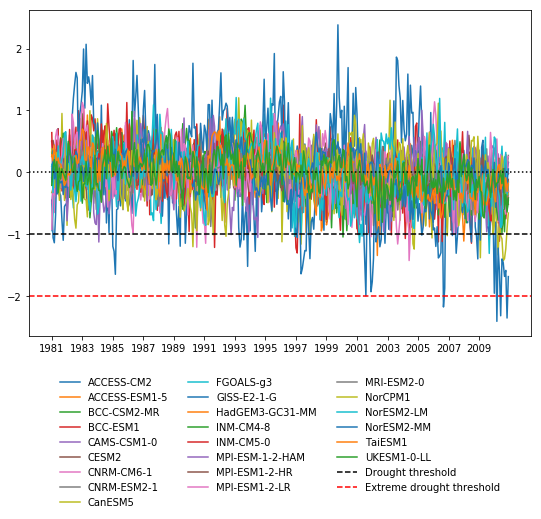

In [16]:
##plot time series

fig = plt.figure(figsize = (9,6))

ax =  fig.add_subplot(111)

#turn into dataframe and extract year
spei_df = cube_to_frame(spei_dict)
#print(spei_df.head(5))
#print(spei_df.tail(5))

for model in np.unique(spei_df['model']):
    print(model)
    #continue
    #years =  np.unique(spei_df['year'])
    #print(years)
    ax.plot(spei_df['value'][spei_df.model==model], label=model)#, c = 'black', label=model)
        
ax.set_xticks(np.arange(0, 360, 24))
ax.set_xticklabels(years[::2])
ax.axhline(y = 0, color = 'black', linestyle = 'dotted')
ax.axhline(y = -1, color = 'black', linestyle = 'dashed', label = 'Drought threshold')
ax.axhline(y = -2, color = 'red', linestyle = 'dashed', label = 'Extreme drought threshold')

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.10), ncol = 3, frameon = False)
        
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/historical_spei_multi_model.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')